In [1]:
import pandas as pd
import numpy as np
import pickle
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Some handy functions

In [2]:
# Functions for processing input

def convert_Actigraph_datetime(row):
    """Convert string in column 'time' in H:M:S format to datetime"""
    return pd.to_datetime(row['time'], format='%H:%M:%S').time()

def convert_Activity_Start_datetime(row):
    """Convert string in column 'Start' in H:M format to datetime"""
    return pd.to_datetime(row['Start'], format='%H:%M').time()

def convert_Activity_End_datetime(row):
    """Convert string in column 'End' in H:M format to datetime"""
    if row['End'] == '24:00':
        return pd.to_datetime('0:00', format='%H:%M').time()
    elif pd.isnull(row['End']):
        return row['Start']
    else:
        return pd.to_datetime(row['End'], format='%H:%M').time()

def label_actigraph(row, df):
    """For each row in Actigraph_df, check if that time is part of activity log. If so, return activity code(s)"""
    day = row['day']
    time = row['time']
    label = []  
    for i in range(len(df)):
        if day == df.Day.loc[i] and ((time >= df.Start.loc[i]) and (time <= df.End.loc[i])):
            label.append(df.Activity.loc[i])
    if label:
        return label
    else:
        label.append(0)
        return label

def RMSSD(RR_list):
    return np.sqrt(np.sum((np.diff((np.array(RR_list)*1000))**2)/(len(RR_list)-1)))

def correct_day(row):
    if (row['day'] != 1) and (row['day'] != 2):
        return 2
    else:
        return row['day']

# Identify 1-min start/ end indices

### Find the index positions that define the beginning and end of each user

In [ ]:
# read in the labelled activities
with open('Actigraphy_labelled.pickle','rb') as read_file:
    Actigraphy_labelled = pickle.load(read_file)


In [5]:
#reset the index
Actigraphy_labelled = Actigraphy_labelled.reset_index()

# Remove unnecessary columnns
Actigraphy_labelled = Actigraphy_labelled.drop(columns=['index'])
Actigraphy_labelled

,Unnamed: 0,Axis1,Axis2,Axis3,Steps,HR,Inclinometer Off,Inclinometer Standing,Inclinometer Sitting,Inclinometer Lying,Vector Magnitude,day,time,User,Activity
0,82,0,0,0,0,68.0,0,1,0,0,0.00,1,10:10:22,1,[2]
1,83,11,4,7,1,68.0,0,1,0,0,13.64,1,10:10:23,1,[2]
2,84,0,21,10,0,68.0,0,0,1,0,23.26,1,10:10:24,1,[2]
3,85,0,1,24,0,68.0,0,0,1,0,24.02,1,10:10:25,1,[2]
4,86,34,14,63,1,154.0,0,1,0,0,72.95,1,10:10:26,1,[2]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1462673,84411,90,115,80,0,72.0,0,1,0,0,166.51,2,08:38:51,22,[0]
1462674,84412,33,49,28,1,72.0,0,1,0,0,65.38,2,08:38:52,22,[0]
1462675,84413,32,25,34,0,72.0,0,1,0,0,52.96,2,08:38:53,22,[0]
1462676,84414,59,28,188,1,72.0,0,1,0,0,199.02,2,08:38:54,22,[0]


In [6]:
#make the user values into a numpy array
user = np.array(Actigraphy_labelled['User'])
type(user)

# find end position for each user
user_ends = list(np.where(user[:-1] != user[1:])[0])
user_ends.append(len(user)-1)

# Find start position for each user
user_starts = [0]
user_starts.extend([i+1 for i in user_ends[:-1]])


### Find the index positions that define the beginning and end of 1 min intervals

In [93]:
start_list = []
end_list = []

# iterate through each user
for idx in range(len(user_starts)):
    
    # iterate through each row of each user
    for i in range(user_starts[idx],user_ends[idx]+1):
        if i == user_starts[idx]:
            start_list.append(i)
            start_time = Actigraphy_labelled.time.iloc[i]
            end_time = (dt.datetime.combine(dt.date(1,1,1),start_time) + dt.timedelta(minutes = 1)).time()
        # until we get to the last row for a user, do...
        elif i != user_ends[idx]:
            # skip rows until we get to the first time that is 1 mins or more from the current interval start time
            if Actigraphy_labelled.time.iloc[i] >= end_time:
                start_time = Actigraphy_labelled.time.iloc[i]
                end_time = (dt.datetime.combine(dt.date(1,1,1),start_time) + dt.timedelta(minutes = 1)).time()
                end_list.append(i-1)
                start_list.append(i)
            elif i >= (start_list[-1]+60):
                start_time = Actigraphy_labelled.time.iloc[i]
                end_time = (dt.datetime.combine(dt.date(1,1,1),start_time) + dt.timedelta(minutes = 1)).time()
                end_list.append(i-1)
                start_list.append(i)
            
        else:
            end_list.append(i)
            print(i)

66433
125315
190455
254026
316440
381956
448699
507655
567432
623266
689125
755090
820899
885598
953348
1022103
1088643
1152273
1219687
1283564
1347995
1413954


### Average data within 1 min intervals

In [100]:
# Calculate mean within windows
mean_intervals = []
for i, j in zip(start_list, end_list):
    mean_intervals.append(np.mean(Actigraphy_labelled.iloc[i:j+1,:]))
    
# Put interval data into a dataframe
df = pd.DataFrame(mean_intervals)
df['n_rows'] = np.array(end_list) - np.array(start_list) + 1
df['start_time'] = [Actigraphy_labelled.time.iloc[i] for i in start_list]
df['end_time'] = [Actigraphy_labelled.time.iloc[i] for i in end_list]
df

,Axis1,Axis2,Axis3,Steps,HR,Inclinometer Off,Inclinometer Standing,Inclinometer Sitting,Inclinometer Lying,Vector Magnitude,day,User,n_rows,start_time,end_time
0,2.750000,6.500000,10.250000,0.250000,68.000000,0.000000,0.500000,0.500000,0.000000,15.230000,1.0,1.0,4,10:10:22,10:10:25
1,73.895833,70.041667,86.083333,0.416667,97.708333,0.083333,0.875000,0.041667,0.000000,143.938542,1.0,1.0,48,10:12:15,10:13:14
2,30.270833,23.875000,38.000000,0.187500,88.520833,0.458333,0.500000,0.000000,0.041667,60.109375,1.0,1.0,48,10:13:15,10:14:14
3,36.255319,51.531915,49.510638,0.276596,92.829787,0.000000,0.744681,0.106383,0.148936,90.928936,1.0,1.0,47,10:14:15,10:15:14
4,7.632653,3.816327,13.469388,0.081633,89.122449,0.000000,0.204082,0.530612,0.265306,18.892245,1.0,1.0,49,10:15:15,10:16:09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27798,60.185185,27.166667,70.925926,1.333333,77.796296,0.000000,1.000000,0.000000,0.000000,103.716667,2.0,22.0,54,08:33:44,08:34:43
27799,31.518519,33.444444,56.666667,0.685185,76.148148,0.000000,0.740741,0.259259,0.000000,80.549630,2.0,22.0,54,08:34:50,08:35:49
27800,16.611111,9.777778,48.111111,0.277778,62.500000,0.000000,0.500000,0.500000,0.000000,53.436111,2.0,22.0,54,08:35:56,08:36:55
27801,18.000000,19.629630,36.629630,0.259259,65.722222,0.000000,0.518519,0.481481,0.000000,50.119444,2.0,22.0,54,08:37:02,08:38:01


### Only include rows that are between 45 and 60 seconds

In [101]:
print('{:.1f}% of intervals are between 45 and 60 seconds. Keep those...'\
      .format((len(df[df['n_rows'] >= 45]) / len(df))*100))

df = df[df['n_rows']>=45]
df

91.3% of intervals are between 45 and 60 seconds. Keep those...


,Axis1,Axis2,Axis3,Steps,HR,Inclinometer Off,Inclinometer Standing,Inclinometer Sitting,Inclinometer Lying,Vector Magnitude,day,User,n_rows,start_time,end_time
1,73.895833,70.041667,86.083333,0.416667,97.708333,0.083333,0.875000,0.041667,0.000000,143.938542,1.0,1.0,48,10:12:15,10:13:14
2,30.270833,23.875000,38.000000,0.187500,88.520833,0.458333,0.500000,0.000000,0.041667,60.109375,1.0,1.0,48,10:13:15,10:14:14
3,36.255319,51.531915,49.510638,0.276596,92.829787,0.000000,0.744681,0.106383,0.148936,90.928936,1.0,1.0,47,10:14:15,10:15:14
4,7.632653,3.816327,13.469388,0.081633,89.122449,0.000000,0.204082,0.530612,0.265306,18.892245,1.0,1.0,49,10:15:15,10:16:09
5,22.666667,23.444444,71.777778,0.277778,90.055556,0.000000,0.592593,0.370370,0.037037,84.071667,1.0,1.0,54,10:16:16,10:17:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27797,61.351852,26.907407,52.444444,1.537037,82.814815,0.000000,1.000000,0.000000,0.000000,88.516481,2.0,22.0,54,08:32:38,08:33:37
27798,60.185185,27.166667,70.925926,1.333333,77.796296,0.000000,1.000000,0.000000,0.000000,103.716667,2.0,22.0,54,08:33:44,08:34:43
27799,31.518519,33.444444,56.666667,0.685185,76.148148,0.000000,0.740741,0.259259,0.000000,80.549630,2.0,22.0,54,08:34:50,08:35:49
27800,16.611111,9.777778,48.111111,0.277778,62.500000,0.000000,0.500000,0.500000,0.000000,53.436111,2.0,22.0,54,08:35:56,08:36:55


In [102]:
# pickle the 1 min intervals
with open('one_min_intervals.pickle', 'wb') as to_write:
    pickle.dump(df, to_write)

# Pick out sleep times

In [2]:
# read in the one minute intervals
with open('one_min_intervals.pickle','rb') as read_file:
    one_min_intervals = pickle.load(read_file)

#reset the index
one_min_intervals = one_min_intervals.reset_index()

# Remove unnecessary columnns
one_min_intervals = one_min_intervals.drop(columns=['index'])

one_min_intervals

,Axis1,Axis2,Axis3,Steps,HR,Inclinometer Off,Inclinometer Standing,Inclinometer Sitting,Inclinometer Lying,Vector Magnitude,day,User,n_rows,start_time,end_time
0,73.895833,70.041667,86.083333,0.416667,97.708333,0.083333,0.875000,0.041667,0.000000,143.938542,1.0,1.0,48,10:12:15,10:13:14
1,30.270833,23.875000,38.000000,0.187500,88.520833,0.458333,0.500000,0.000000,0.041667,60.109375,1.0,1.0,48,10:13:15,10:14:14
2,36.255319,51.531915,49.510638,0.276596,92.829787,0.000000,0.744681,0.106383,0.148936,90.928936,1.0,1.0,47,10:14:15,10:15:14
3,7.632653,3.816327,13.469388,0.081633,89.122449,0.000000,0.204082,0.530612,0.265306,18.892245,1.0,1.0,49,10:15:15,10:16:09
4,22.666667,23.444444,71.777778,0.277778,90.055556,0.000000,0.592593,0.370370,0.037037,84.071667,1.0,1.0,54,10:16:16,10:17:15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25391,61.351852,26.907407,52.444444,1.537037,82.814815,0.000000,1.000000,0.000000,0.000000,88.516481,2.0,22.0,54,08:32:38,08:33:37
25392,60.185185,27.166667,70.925926,1.333333,77.796296,0.000000,1.000000,0.000000,0.000000,103.716667,2.0,22.0,54,08:33:44,08:34:43
25393,31.518519,33.444444,56.666667,0.685185,76.148148,0.000000,0.740741,0.259259,0.000000,80.549630,2.0,22.0,54,08:34:50,08:35:49
25394,16.611111,9.777778,48.111111,0.277778,62.500000,0.000000,0.500000,0.500000,0.000000,53.436111,2.0,22.0,54,08:35:56,08:36:55


### Read in sleep data

In [3]:
def convert_to_datetime(row, col):
    """Convert string in column 'time' in H:M:S format to datetime"""
    return pd.to_datetime(row[col], format='%H:%M').time()

root = 'data/DataPaper/user_'
sleep_df = pd.DataFrame()

for i in range(1,23):

    # Define paths
    path = root + str(i) + '/sleep.csv'
    
    # Read in the data
    df = pd.read_csv(path)

    # Create a 'user' column in the df
    df['User'] = i
    
    # Convert time string to datetime
    df['In Bed Time'] = df.apply(convert_to_datetime, col='In Bed Time', axis=1)
    df['Out Bed Time'] = df.apply(convert_to_datetime, col='Out Bed Time', axis=1)
    df['Onset Time'] = df.apply(convert_to_datetime, col='Onset Time', axis=1)
        
    # Append df to main RR_df
    sleep_df = sleep_df.append(df)
    sleep_df = sleep_df.reset_index()
    sleep_df = sleep_df.drop(columns=['index','Unnamed: 0'])

# There are typos where out bed date is 1, but should be 2
sleep_df['Out Bed Date'] = 2

### Subset one minute intervals to just those that occur during sleep

In [4]:
sleep_indices = []

# Get sleep and interval data by user
for i in np.arange(1,23):
    tmp_sleep_df = sleep_df[sleep_df['User']==i]
    tmp_intervals = one_min_intervals[one_min_intervals['User']==i]
    
    # Get each row of sleep time:
    for onset_time, wake_time, onset_day, wake_day in zip(tmp_sleep_df['Onset Time'],tmp_sleep_df['Out Bed Time'],tmp_sleep_df['Onset Date'],tmp_sleep_df['Out Bed Date']):
        
        # Get each row of interval time:
        for int_day, int_start_time, int_end_time, idx in zip(tmp_intervals.day, tmp_intervals.start_time, tmp_intervals.end_time, tmp_intervals.index):
            
            # If interval time falls within sleep time, append index:

            # If subject goes to bed on day 1 and wakes up on day 2
            if (onset_day == 1) and (wake_day == 2):

                #if the interval time is before midnight
                if (int_day == 1) and (int_start_time >= onset_time):
                    sleep_indices.append(idx)

                #if the interval time is after midnight:
                if (int_day == 2) and (int_end_time <= wake_time):
                    sleep_indices.append(idx)

            #if you go to bed on day 2 and wake up on day 2:
            if (onset_day == 2) and (wake_day == 2):
                if (int_day == 2) and (int_start_time >= onset_time) and (int_end_time <= wake_time):
                    sleep_indices.append(idx)

In [5]:
# Pull out the one minute interval rows that occur duing sleep based on sleep_indices
sleep_intervals = one_min_intervals.iloc[sleep_indices]

sleep_intervals = sleep_intervals.reset_index()
sleep_intervals = sleep_intervals.drop(columns='index')

# Collect RR data for the 1-min sleep intervals

In [ ]:
"""# Read in the RR data

root = 'data/DataPaper/user_'
RR_df = pd.DataFrame()

for i in range(1,23):

    # Define paths
    path = root + str(i) + '/RR.csv'
    
    # Read in the data
    df = pd.read_csv(path)

    # Create a 'user' column in the df
    df['User'] = i
    
    # Convert time string to datetime
    df['time'] = df.apply(convert_Actigraph_datetime, axis=1)
        
    # Append df to main RR_df
    RR_df = RR_df.append(df)

# pickle the RR_df
with open('RR_df.pickle', 'wb') as to_write:
    pickle.dump(RR_df, to_write)"""

# Read in the pickled RR_df:
with open('RR_df.pickle','rb') as read_file:
    RR_df = pickle.load(read_file)
    
# Correct day error for Subject 8 and 9
RR_df['day'] = RR_df.apply(correct_day, axis=1)

### Create bins of RRs according to the sleep interval times

In [111]:
# Some empty lists to attach data for each sleep interval
AI_idx = []
RRs = []

# Get sleep intervals and RR data by user
for i in np.arange(1,23):
    tmp_intervals = sleep_intervals[sleep_intervals['User']==i]
    tmp_RR = RR_df[RR_df['User']==i]

    # Keep track of how we're doing
    print(i) 
    
    # For each interval...
    for day, user, start, end, idx in zip(tmp_intervals.day, tmp_intervals.User, \
                                     tmp_intervals.start_time, tmp_intervals.end_time, tmp_intervals.index):

        # Define the index to which the RRs are attached
        AI_idx.append(idx)

        # Make an empty list to hold RRs for the current interval
        RR_list = []

        # Loop through each row in the user's RR data
        for RR_day, RR_user, RR_time, RR_RR in zip(tmp_RR.day, tmp_RR.User, tmp_RR.time, tmp_RR.ibi_s):

            # If the RR time falls within the interval, append to the interval's RR list
            if (RR_user == user) and (RR_day == day) and (RR_time >= start) and (RR_time <= end):
                RR_list.append(RR_RR)

        # Append the interval RR list to the entire data RR list
        RRs.append(RR_list)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22


In [112]:
# pickle the indices and RR lists
with open('AI_idx_one_min.pickle', 'wb') as to_write:
    pickle.dump(AI_idx, to_write)
    
with open('RRs_one_min.pickle', 'wb') as to_write:
    pickle.dump(RRs, to_write)

# Filter the RR data

In [9]:
# read in the Activity Interval index
with open('AI_idx_one_min.pickle','rb') as read_file:
    AI_idx = pickle.load(read_file)

# read in the RRs
with open('RRs_one_min.pickle','rb') as read_file:
    RRs = pickle.load(read_file)

In [10]:
# 0.3 RR = 200 bpm
# 3 RR = 20 bpm
filtered_RRs=[]
for series in RRs:
    filtered = [i for i in series if ((i > 0.3) & (i < 3))]
    filtered_mean = np.mean(filtered)
    filtered_std = np.std(filtered)
    lower = filtered_mean-(filtered_std)
    upper = filtered_mean+(filtered_std)
    filtered_RRs.append([i for i in filtered if ((i >= lower) & (i <= upper))])

In [11]:
# determine starting series size
start_len = np.array([len(series) for series in RRs])

# determine the ending series size
end_len = np.array([len(series) for series in filtered_RRs])

In [12]:
# what percent of each series is lost by filtering
frac_lost = (start_len - end_len) / start_len

In [13]:
# we want to get rid of series that lost more than averge + std
threshold = np.mean(frac_lost) + np.std(frac_lost)
keep_RRs = np.where(frac_lost <= threshold)
final_RRs = [filtered_RRs[i] for i in keep_RRs[0]]

### Get the RMSSDs

In [14]:
# Calculate RMSSD
RMSSDs = [RMSSD(series) for series in final_RRs]

# apply filter to RRs
sleep_intervals = sleep_intervals.iloc[keep_RRs[0],:]

# append RMSSDs to the df
sleep_intervals['RMSSD'] = RMSSDs

In [15]:
sleep_intervals = sleep_intervals.reset_index()
sleep_intervals = sleep_intervals.drop(columns='index')
sleep_intervals

with open('sleep_intervals.pickle', 'wb') as to_write:
    pickle.dump(sleep_intervals, to_write)

# Build a time series df

In [16]:
# read in the one minute intervals
with open('sleep_intervals.pickle','rb') as read_file:
    sleep_intervals = pickle.load(read_file)

In [17]:
#Subset to the columns we need...

interval_df = sleep_intervals[['RMSSD', 'start_time', 'end_time', 'User', 'Vector Magnitude', 'HR']]
interval_df.head(10)

,RMSSD,start_time,end_time,User,Vector Magnitude,HR
0,72.411248,00:46:19,00:47:18,1.0,0.0,68.148148
1,61.160678,00:47:35,00:48:34,1.0,0.0,61.622642
2,75.846391,00:48:41,00:49:40,1.0,0.0,62.333333
3,68.963532,00:49:47,00:50:46,1.0,0.0,62.584906
4,75.524074,00:50:53,00:51:52,1.0,0.0,61.055556
5,65.628662,00:51:59,00:52:58,1.0,0.0,60.481481
6,70.155455,00:54:05,00:55:04,1.0,0.0,59.625000
7,58.598741,00:56:10,00:57:09,1.0,0.0,59.740741
8,51.326281,00:57:16,00:58:15,1.0,0.0,59.962963
9,72.910183,00:58:25,00:59:24,1.0,0.0,60.259259


In [ ]:
# create a new empty df to which we can append time-series by user
series_df = pd.DataFrame()

# create time series for each user - this way shifts don't move data between users
for i in np.arange(1,23):
    
    # get data for each user
    df = interval_df[interval_df['User']==i]
    
    # give each row data from the previous 3 time points
    df['RMSSD1'] = df.RMSSD.shift(1)
    df['start1'] = df.start_time.shift(1)
    df['HR1'] = df.HR.shift(1)

    df['RMSSD2'] = df.RMSSD1.shift(1)
    df['start2'] = df.start1.shift(1)
    df['HR2'] = df.HR1.shift(1)

    df['RMSSD3'] = df.RMSSD2.shift(1)
    df['start3'] = df.start2.shift(1)
    df['HR3'] = df.HR2.shift(1)

    df['RMSSD4'] = df.RMSSD3.shift(1)
    df['start4'] = df.start3.shift(1)
    df['HR4'] = df.HR3.shift(1)

    df['RMSSD5'] = df.RMSSD4.shift(1)
    df['start5'] = df.start4.shift(1)
    df['HR5'] = df.HR4.shift(1)

    df['RMSSD6'] = df.RMSSD5.shift(1)
    df['start6'] = df.start5.shift(1)
    df['HR6'] = df.HR5.shift(1)



# Add user data to the full time-series df
    series_df = series_df.append(df)

series_df

In [47]:
#as long as the 6 prior times are within 10 mins of the start of the head interval

def check_time_coverage(row):
    """Check if prior 6 time points are within 10 mins of current interval"""
    
    # define the time 10 mins before current interval start time
    delta = dt.timedelta(hours=23, minutes = 50)
    back_10 = (dt.datetime.combine(dt.date(1,1,1),row['start_time']) + delta).time()
    
    # drop rows that have NaN
    if row.isnull().any():
        return 1
    
    # keep rows if 3 prior time points are within 5 mins
    if (row['start6'] >= back_10):
        return 0
    
    # drop rows if 3 prior time points are not within 5 mins
    else:
        return 1

# Apply the function to each row
series_df['drop'] = series_df.apply(check_time_coverage, axis=1)

In [48]:
# drop the marked rows
series_df = series_df[series_df['drop']==0]
series_df = series_df.drop(columns='drop')

# reset index and pickle
series_df = series_df.reset_index()
series_df = series_df.drop(columns='index')

In [49]:
# pickle the series_df
with open('series_df.pickle', 'wb') as to_write:
    pickle.dump(series_df, to_write)

# Build X and y

In [3]:
# read in the labelled activity intervals
with open('series_df.pickle','rb') as read_file:
    series_df = pickle.load(read_file)

In [4]:
# Select values for X and y
X = series_df[['RMSSD','RMSSD1','RMSSD2','RMSSD3','RMSSD4','RMSSD5','RMSSD6','HR','HR1','HR2','HR3','HR4','HR5','HR6']]

# If there is any movement, label as 1
y = (series_df['Vector Magnitude'] > 0).astype(int)

### Train, val, test split

In [5]:
# Upsample the minority class
from imblearn.over_sampling import SMOTE
X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X,y)

# Create a validation set
X_train, X_val, y_train, y_val = train_test_split(X_smoted, y_smoted, test_size=0.1)

# Create a train and test set
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.11)

# RF Model

In [13]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 100, max_features = 3, n_jobs=-1)
rf.fit(X_train,y_train)

RandomForestClassifier(max_features=3, n_jobs=-1)

In [18]:
y_pred = rf.predict(X_test)

In [19]:
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report, recall_score, precision_score, accuracy_score

              precision    recall  f1-score   support

           0       0.91      0.93      0.92       416
           1       0.93      0.91      0.92       439

    accuracy                           0.92       855
   macro avg       0.92      0.92      0.92       855
weighted avg       0.92      0.92      0.92       855



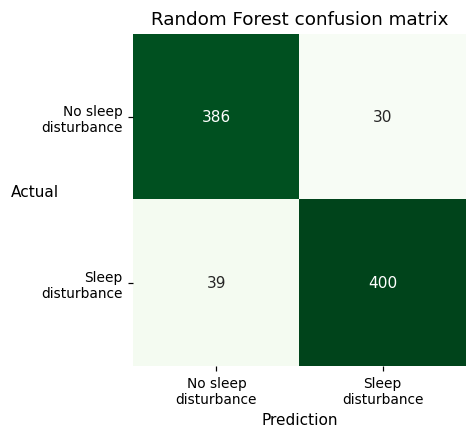

In [20]:
# This is the updated threshold where precision and recall cross over
y_preds = (rf.predict_proba(X_test)[:, 1] > 0.5)
print(classification_report(y_test, y_preds))

import seaborn as sns
from textwrap import wrap
cf_matrix = confusion_matrix(y_test, y_preds)
plt.figure(dpi=110)
sns.heatmap(cf_matrix, cmap=plt.cm.Greens, annot=True, square=True, fmt='g',
           cbar=False)
label_names = ['No sleep disturbance','Sleep disturbance']
labels = ['\n'.join(wrap(l,12)) for l in label_names]
plt.xticks([0.5,1.5],labels, fontsize=9)
plt.yticks([0.5,1.5],labels,rotation=0, fontsize=9)
plt.xlabel('Prediction')
plt.ylabel('Actual', rotation = 0)
plt.title('Random Forest confusion matrix');

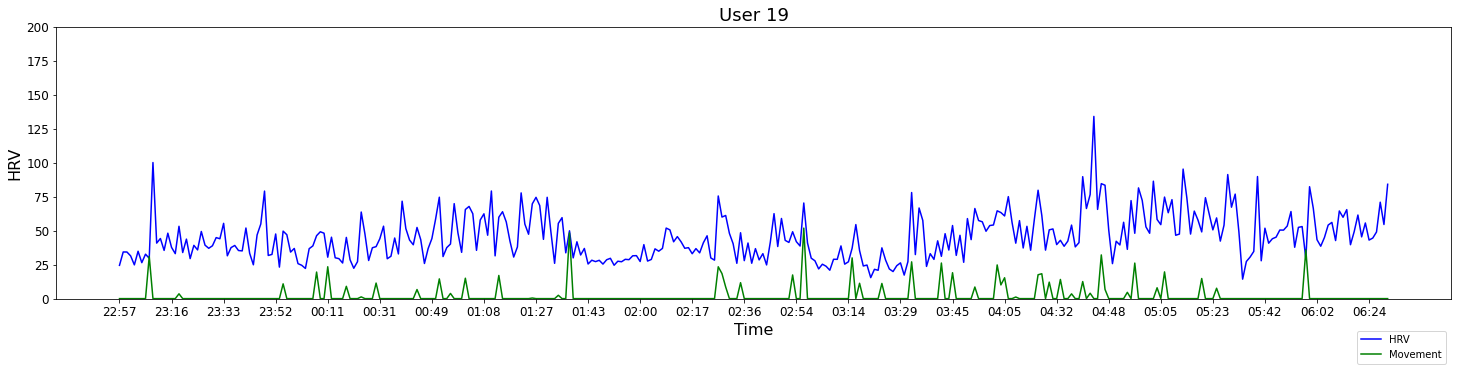

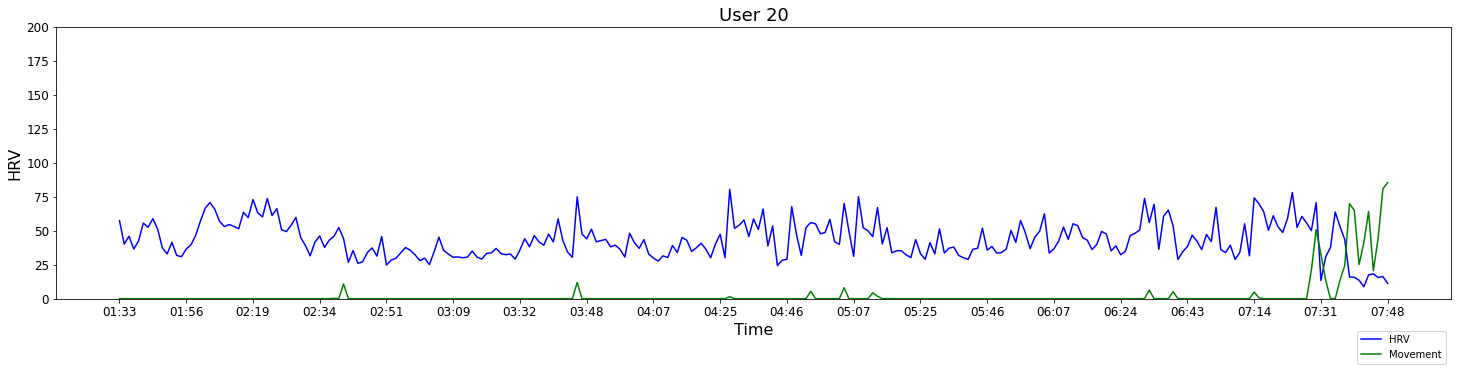

In [8]:
for id in range(19,21):
    tmp = sleep_intervals[sleep_intervals['User']==id]
    if len(tmp):
        time_ticks = []
        start = tmp.index[0]
        end = tmp.index[-1]+1
        for i in np.arange(start,end,14):
            time_ticks.append(tmp.start_time[i].strftime('%H:%M'))

        x = np.arange(start, end,1)
        plt.figure(figsize=(25,5))
        plt.plot(x, tmp.RMSSD, color='b', label='HRV')
        plt.plot(x, tmp['Vector Magnitude'], color='g',label='Movement')

        plt.legend(bbox_to_anchor=(1, -.1), fontsize=10)
        plt.ylim((0,200))
        plt.xlabel('Time', fontsize=16)
        plt.ylabel('HRV', fontsize=16)
        plt.yticks(fontsize=12)
        plt.xticks(np.arange(start, end,14), time_ticks, fontsize=12)
        plt.title('User {}'.format(id),fontsize=18);